In [ ]:
!pip install transformers
!pip install pytorch-lightning
!pip install torch

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import transformers
from transformers import BertTokenizer,BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
import torch
from sklearn.model_selection import train_test_split


# **Load the dataset**

In [3]:
# Load the dataset
file_path = '/content/Evaluation-dataset.csv'
data = pd.read_csv(file_path, header=None)

# Display the first few rows to understand its structure
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,Tires where delivered to the garage of my choi...,garage service positive,ease of booking positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Easy Tyre Selection Process, Competitive Prici...",garage service positive,value for money positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Very easy to use and good value for money.,value for money positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Really easy and convenient to arrange,ease of booking positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,It was so easy to select tyre sizes and arrang...,location positive,value for money positive,ease of booking positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Dataset transformation

In [4]:
# Assuming the first column (index 0) contains the reviews, and the rest are labels
label_columns = data.columns[1:]  # All columns after the first

# Extract unique labels, ensuring 'NaN' values are handled correctly
unique_labels = pd.unique(data[label_columns].fillna('NaN').values.ravel('K'))
unique_labels = [label for label in unique_labels if label != 'NaN']

# Create a dictionary to map each label to a new column with binary values
label_mapping = {label: [] for label in unique_labels}

# Populate the dictionary with binary values for each review
for _, row in data.iterrows():
    review_labels = set(row[1:].dropna().values)  # Get the labels for the review, excluding NaNs
    for label in label_mapping:
        label_mapping[label].append(int(label in review_labels))

# Create a DataFrame from the label mapping
label_df = pd.DataFrame(label_mapping)

# Concatenate the original reviews (now without a header, so referred by index) with the new label DataFrame
df = pd.concat([data.iloc[:, 0].reset_index(drop=True), label_df], axis=1)
df.rename(columns={df.columns[0]: "reviews"}, inplace=True)
# The first column will still contain the reviews; the new columns represent unique labels
# Show the transformed DataFrame structure
df.head()

,reviews,garage service positive,value for money positive,ease of booking positive,location positive,length of fitting positive,ease of booking negative,tyre quality positive,garage service negative,wait time negative,...,recommended a great local shop for fitting,mobile fitter didn't arrive positive,polite staff,slick delivery service and good fitter.,change of time positive,discount not applied positive,failed payment positive,late notice positive,call wait time positive,no stock positive
0,Tires where delivered to the garage of my choi...,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Easy Tyre Selection Process, Competitive Prici...",1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Very easy to use and good value for money.,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Really easy and convenient to arrange,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,It was so easy to select tyre sizes and arrang...,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(10132, 107)

In [6]:
df.isnull().sum()

reviews                          0
garage service positive          0
value for money positive         0
ease of booking positive         0
location positive                0
                                ..
discount not applied positive    0
failed payment positive          0
late notice positive             0
call wait time positive          0
no stock positive                0
Length: 107, dtype: int64

In [7]:
train_df,test_df = train_test_split(df,test_size=0.2)
train_df.shape,test_df.shape

((8105, 107), (2027, 107))

In [ ]:
CLASSES = df.columns.to_list()[1:]
CLASSES

<Axes: >

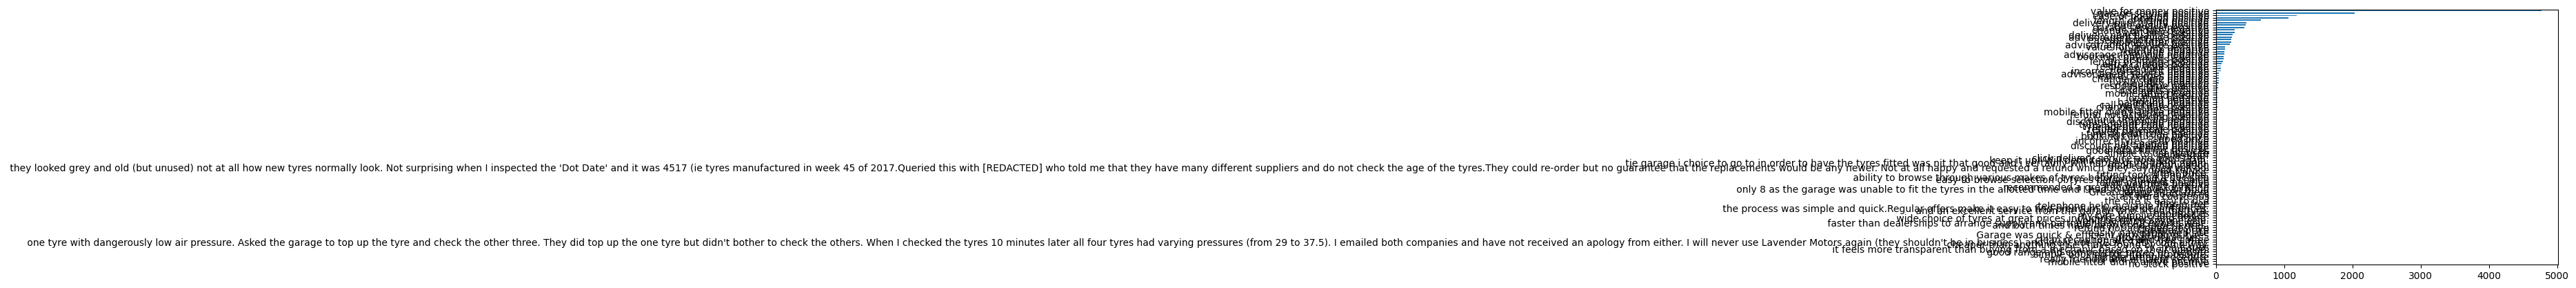

In [9]:
df[CLASSES].sum().sort_values().plot(kind='barh')

In [ ]:
toxic_df = df[df[CLASSES].sum(axis=1) >0]
toxic_df.shape

In [11]:
clean_df = df[df[CLASSES].sum(axis=1) ==0]
clean_df.shape

(2003, 107)

# Model

In [12]:
BERT_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Data preprocessing

In [13]:
class ToxicCommentsDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_len: int = 128
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):

        single_row = self.data.iloc[index]


        comment = single_row.reviews
        labels = single_row[CLASSES]

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "comment_text": comment,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(labels, dtype=torch.float)
        }


train_dataset = ToxicCommentsDataset(train_df, tokenizer, max_len=128)
sample_data = train_dataset[0]
print(sample_data["comment_text"])
print()
print(sample_data["input_ids"])
print()
print(sample_data["attention_mask"])
print()
print(sample_data["labels"])


Easy to select correct tyre and local garage to fit them on website. Anthony Luff and co were friendly and helpful. I would use them again.

tensor([  101, 12167,  1106,  8247,  5663,   189, 10930,  1105,  1469,  7419,
         1106,  4218,  1172,  1113,  3265,   119,  4140, 14557,  3101,  1105,
         1884,  1127,  4931,  1105, 14739,   119,   146,  1156,  1329,  1172,
         1254,   119,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
 

In [14]:
class ToxicCommentDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_len=128):
        super().__init__()
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_len = max_len

    def setup(self,stage = None):
        self.train_dataset = ToxicCommentsDataset(self.train_df, self.tokenizer, self.max_len)
        self.test_dataset = ToxicCommentsDataset(self.test_df, self.tokenizer, self.max_len)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            num_workers=4
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            num_workers=4
        )

In [15]:
EPOCHS = 10
BATCH_SIZE = 32

In [16]:
data_module = ToxicCommentDataModule(
    train_df,
    test_df,
    tokenizer,
    batch_size=BATCH_SIZE
)
data_module.setup()

# Model Building

In [17]:
import torch.nn as nn
class ToxicCommentClassifier(pl.LightningModule):
    def __init__(self, n_classes: int, steps_per_epoch=None, n_epochs=None):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.5)  # Adjust dropout rate as needed
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, n_classes)
        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {
            "loss": loss,
            "predictions": outputs,
            "labels": labels
        }

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        loss, outputs = self(input_ids, attention_mask, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def on_train_epoch_end(self):
        labels = []
        predictions = []


    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        warmup_steps = self.steps_per_epoch // 3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
        scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer], [scheduler]

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=5e-5, weight_decay=0.01)
        scheduler = {'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3),
                     'monitor': 'val_loss',
                     'interval': 'epoch',
                     'frequency': 1}
        return [optimizer], [scheduler]

model = ToxicCommentClassifier(
    n_classes=len(CLASSES),
    steps_per_epoch=len(train_df)//BATCH_SIZE,
    n_epochs=EPOCHS
)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [18]:
trainer = pl.Trainer(max_epochs=EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
from pytorch_lightning.callbacks import EarlyStopping
early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=3,
   verbose=True,
   mode='min'
)

trainer = pl.Trainer(callbacks=[early_stop_callback], max_epochs=10)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [20]:
trainer.fit(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | dropout    | Dropout   | 0     
2 | classifier | Linear    | 81.5 K
3 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.567   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.054


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.041


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.035


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.030


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.028


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.025


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.024


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.023


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.022


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.022
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [21]:
trainer.save_checkpoint("last-checkpoint.ckpt")

In [22]:
trained_model = ToxicCommentClassifier.load_from_checkpoint("last-checkpoint.ckpt", n_classes=len(CLASSES))
trained_model.freeze()

# Testing on example

In [47]:
test_example = "Very professional and helpful staff.Strongly recommend although I had slightly problems with one of the garage's date after I selected the convenient garage with their availability date and hour to fit four tyres for my car.15 minutes later I received an email from [REDACTED], saying that the nominated garage is fully booked on that day ( when I booked there were showing other three different times as well on that day !! ).The garages's deta bases have to be up to date with [REDACTED] system. Many thanks to [REDACTED] staff were resolved the problem very quickly."

In [48]:
encoding = tokenizer.encode_plus(
    test_example,
    add_special_tokens=True,
    max_length=128,
    return_token_type_ids=False,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    return_tensors="pt"
)

In [49]:
model.eval()
_, preds = model(encoding["input_ids"], encoding["attention_mask"])
preds = preds.flatten().detach().numpy()

In [50]:
predictions = []
for idx, label in enumerate(CLASSES):
    if preds[idx] > 0.2:
        predictions.append((label, round(preds[idx], 2)))

predictions

[('garage service positive', 0.97),
 ('wait time positive', 0.34),
 ('advisor/agent service positive', 0.61),
 ('advisoragent service positive', 0.8)]